In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

2024-03-05 12:05:47.204855: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 12:05:47.226561: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 12:05:47.565550: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-05 12:05:47.567127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 12:05:51.589666: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
plt.style.use('ggplot')

In [3]:
ticker = yf.Ticker('AAPL')
START = datetime.datetime(2015, 1, 1)
END = datetime.datetime(2023, 12, 31) 
df = ticker.history(start=START, end=END)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,24.895672,24.906848,23.992732,24.435263,212818400,0.0,0.0
2015-01-05 00:00:00-05:00,24.202828,24.283288,23.559148,23.746887,257142000,0.0,0.0
2015-01-06 00:00:00-05:00,23.811702,24.010617,23.384816,23.749123,263188400,0.0,0.0
2015-01-07 00:00:00-05:00,23.959216,24.182716,23.847466,24.082142,160423600,0.0,0.0
2015-01-08 00:00:00-05:00,24.412920,25.065540,24.294463,25.007429,237458000,0.0,0.0


<Axes: title={'center': 'Apple Stock Price'}, xlabel='Date'>

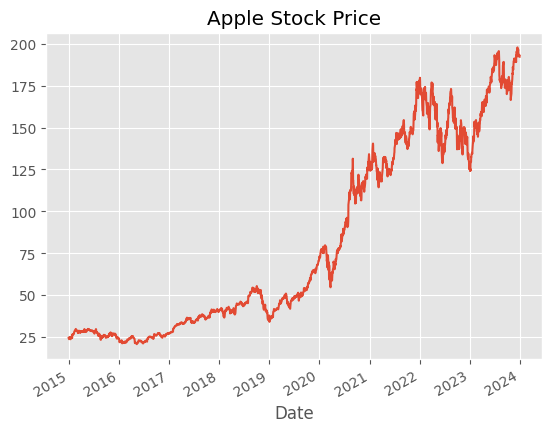

In [4]:
df['Close'].plot(title='Apple Stock Price')

In [5]:
df = df.reset_index()
print(f'Dimemsion of dataframe: {df.shape}') 
df.head()

Dimemsion of dataframe: (2264, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-01-02 00:00:00-05:00,24.895672,24.906848,23.992732,24.435263,212818400,0.0,0.0
1,2015-01-05 00:00:00-05:00,24.202828,24.283288,23.559148,23.746887,257142000,0.0,0.0
2,2015-01-06 00:00:00-05:00,23.811702,24.010617,23.384816,23.749123,263188400,0.0,0.0
3,2015-01-07 00:00:00-05:00,23.959216,24.182716,23.847466,24.082142,160423600,0.0,0.0
4,2015-01-08 00:00:00-05:00,24.412920,25.065540,24.294463,25.007429,237458000,0.0,0.0


In [6]:
df = df.drop(['Dividends', 'Stock Splits', 'Date'], axis=1)
df

,Open,High,Low,Close,Volume
0,24.895672,24.906848,23.992732,24.435263,212818400
1,24.202828,24.283288,23.559148,23.746887,257142000
2,23.811702,24.010617,23.384816,23.749123,263188400
3,23.959216,24.182716,23.847466,24.082142,160423600
4,24.412920,25.065540,24.294463,25.007429,237458000
...,...,...,...,...,...
2259,194.931260,195.160978,192.724085,193.353287,37122800
2260,193.363270,193.642911,192.584265,192.803986,28919300
2261,192.244692,193.253399,190.846467,192.903839,48087700
2262,193.892582,194.411923,192.923817,193.333298,34049900


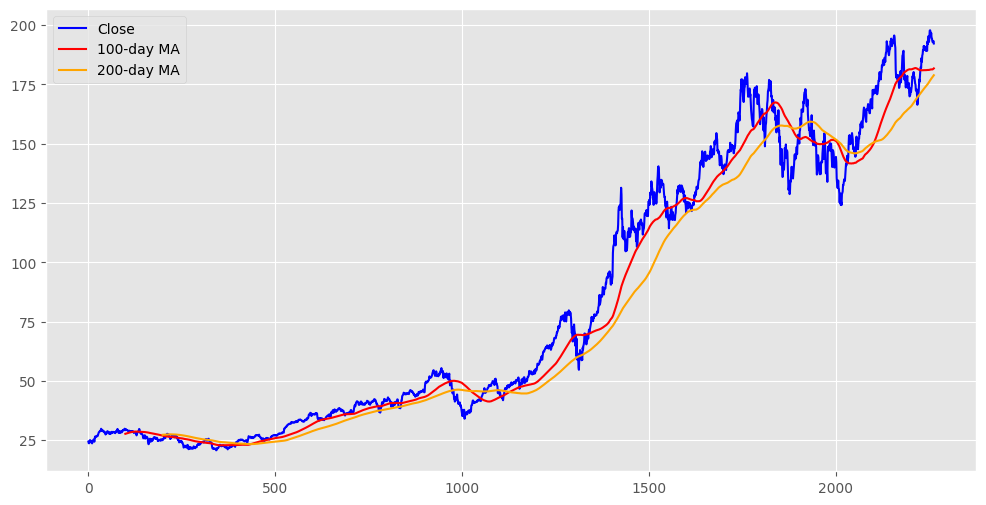

In [7]:
# MA stand for Moving Average helping smooth out 
# the data by creating a constantly updated average price
ma100 = df.Close.rolling(100).mean()
ma200 = df.Close.rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(df.Close, 'b')
plt.plot(ma100, 'r')
plt.plot(ma200, 'orange')
plt.legend(['Close', '100-day MA', '200-day MA'])

In [8]:
training = df.Close[:int(len(df)*0.70)]
testing = df.Close[int(len(df)*0.70):]
print(f'Dimemsion of training data: {training.shape}')  
print(f'Dimemsion of testing data: {testing.shape}')    

Dimemsion of training data: (1584,)
Dimemsion of testing data: (680,)


In [9]:
scaler = MinMaxScaler(feature_range=(0,1))
training = scaler.fit_transform(np.array(training).reshape(-1, 1))
testing = scaler.fit_transform(np.array(testing).reshape(-1, 1))

In [10]:
x_train = []
y_train = []
x_test = []
y_test = []

for i in range(100, training.shape[0]):
    x_train.append(training[i-100:i])
    y_train.append(training[i])
for i in range(100, testing.shape[0]):
    x_test.append(testing[i-100:i])
    y_test.append(testing[i])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [11]:
y_train

array([[0.07450832],
       [0.07168536],
       [0.07217466],
       ...,
       [0.93066028],
       [0.92786914],
       [0.93345156]])

In [12]:
model = Sequential()
# First 
model.add(LSTM(units = 50, activation = 'relu', 
               return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))  
model.add(Dropout(0.2)) 

# Second
model.add(LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

# Third
model.add(LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.4))

# Fourth
model.add(LSTM(units=120, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=3, verbose=1)

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, 
        validation_data=(x_test, y_test),
        callbacks=[early_stopping])

Epoch 1/50


47/47 [==============================] - 27s 384ms/step - loss: 0.0032 - val_loss: 0.0127
Epoch 2/50
47/47 [==============================] - 15s 318ms/step - loss: 0.0036 - val_loss: 0.0110
Epoch 3/50
47/47 [==============================] - 9s 181ms/step - loss: 0.0031 - val_loss: 0.0107
Epoch 4/50
47/47 [==============================] - 8s 179ms/step - loss: 0.0027 - val_loss: 0.0098
Epoch 5/50
47/47 [==============================] - 10s 210ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 6/50
47/47 [==============================] - 14s 306ms/step - loss: 0.0032 - val_loss: 0.0097
Epoch 7/50
47/47 [==============================] - 14s 307ms/step - loss: 0.0030 - val_loss: 0.0094
Epoch 8/50
47/47 [==============================] - 15s 315ms/step - loss: 0.0036 - val_loss: 0.0104
Epoch 9/50
47/47 [==============================] - 15s 311ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 10/50
47/47 [==============================] - 14s 305ms/step - loss: 0.0030 - val_loss: 0.0094
Ep

In [16]:
y_pred = model.predict(x=x_test)
scale_factor = 1 / scaler.scale_
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor


19/19 [==============================] - 2s 62ms/step


In [ ]:
print(scaler.scale_)

: 

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b')
plt.plot(y_pred, 'r')
plt.legend(['Actual', 'Predicted'])
plt.title('Comparing actual and prediction values')

: 

In [ ]:
model.save('lstm_model')
model.save('lstm.keras')

: 